# LLM Inference-time parameters

In this notebook, we explore inference-time parameters of LLMs (like GPT from OpenAI) like temperature or top-p, which control the randomness of the output. These parameter are working on the output distribution of the last softmax layer from the underlying transformer model. At first, we need to look into the softmax function and its properties.

## Softmax
The **softmax function** takes a real-valued vector as input and normalize it into a probability distribution. It is defined as follows:
$$
\begin{align*}
    \sigma\colon \mathbb{R}^d &\to \left\{x\in\mathbb{R}^d\vert x_i\geq 0, \sum_{i=1}^{d}x_i = 1\right\}\\
    x &\mapsto \left(\frac{e^{x_i}}{\sum_{j=1}^{d}e^{x_j}}\right)_{1\leq i\leq d}
\end{align*}
$$

In general, we might be interested in other bases then $e$ too. Therefore, we introduce a new real-valued parameter $c\in\mathbb{R}$ and change the definition of $\sigma$ slightly:

$$
\begin{align*}
    \sigma_c\colon \mathbb{R}^d &\to \left\{x\in\mathbb{R}^d\vert x_i\geq 0, \sum_{i=1}^{d}x_i = 1\right\}\\
    x &\mapsto \left(\frac{e^{c\cdot x_i}}{\sum_{j=1}^{d}e^{c\cdot x_j}}\right)_{1\leq i\leq d}
\end{align*}
$$
Obviously, it holds $\sigma_1 = \sigma$. For convenience, let $\sigma_c(x)_i = \dfrac{e^{c\cdot x_i}}{\sum_{j=1}^{d}e^{c\cdot x_j}}$ be the $i$-th part of the image $\sigma_c(x)$.

Next, we want to investigate on the effect of parameter $c$. For $c=0$, this is easy: we get the discrete uniform distribution. In fact, we see that

$$
\sigma_0(x)_i = \frac{e^{0\cdot x_i}}{\sum_{j=1}^{d}e^{0\cdot x_j}} = \frac{1}{\sum_{j=1}^{d}1} = \frac{1}{d}.
$$

For $c\to\infty$ the softmax function $\sigma_c$ converges to the $\operatorname{argmax}$ function. Indeed, let $\hat{x}=\max(x)$. Then, by extending $\sigma_c(x)_i$ with $\dfrac{e^{-c\cdot\hat{x}}}{e^{-c\cdot\hat{x}}}$ we get 

$$
\sigma_c(x)_i = \dfrac{e^{c\cdot x_i}}{\sum_{j=1}^{d}e^{c\cdot x_j}}\cdot\frac{e^{-c\cdot\hat{x}}}{e^{-c\cdot\hat{x}}} = \frac{e^{c\cdot(x_i-\hat{x})}}{\sum_{j=1}^{d}e^{c\cdot(x_j-\hat{x})}} = \frac{e^{c\cdot(x_i-\hat{x})}}{\sum\limits_{\substack{j=1 \\ x_j\neq\hat{x}}}^{d}e^{c\cdot(x_j-\hat{x})} + 1}.
$$

Since $x_j\neq \hat{x}$ it follows that $x_j-\hat{x}<0$ and hence $\lim_{c\to\infty}e^{c\cdot(x_j-\hat{x})}=0$. Therefore, for $x_i=\hat{x}$ we see that

$$
\lim_{c\to\infty}\sigma_c(x)_i = \lim_{c\to\infty}\frac{e^{c\cdot(x_i-\hat{x})}}{\sum\limits_{\substack{j=1\\ x_j\neq\hat{x}}}^{d}e^{c\cdot(x_j-\hat{x})} + 1} = \lim_{c\to\infty}\frac{1}{\sum\limits_{\substack{j=1\\ x_j\neq\hat{x}}}^{d}e^{c\cdot(x_j-\hat{x})} + 1} = 1.
$$

Analogously, we see that for $x_i\neq\hat{x}$ it holds

$$
\lim_{c\to\infty}\sigma_c(x)_i = \lim_{c\to\infty}\frac{e^{c\cdot(x_i-\hat{x})}}{\sum\limits_{\substack{j=1\\ x_j\neq\hat{x}}}^{d}e^{c\cdot(x_j-\hat{x})} + 1} = 0.
$$

Similarly, we can proof that $\sigma_c$ converges to the $\operatorname{argmin}$ function for $c\to -\infty$.

Now that we have discussed the theory, we want to apply the results. We begin with a simple implementation of the softmax function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

In [2]:
def softmax(vector: np.array, c: float = 1) -> np.array:
    return np.exp(c * vector) / np.sum(np.exp(c * vector))

Next we will implement a simple function plotting a distribution because we are going to do that a lot.

In [3]:
def plot_distribution(ax: plt.Axes, data: np.array, title: str, normalized: bool = True) -> None:
    ax.bar(range(len(data)), data)
    ax.set_title(title)

    if normalized:
        ax.set_ylim(0, 1)
        
    ax.set_xticks(range(len(data)))
    ax.set_xticklabels(["t{}".format(i) for i in range(1, len(data) + 1)])

## Temperature
The temperature $t>0$ is a parameter of an LLM controlling the randomness of the output. It scales the logits (the activations directly before the softmax layer) by dividing each entry by t, i.e. we use the softmax function $\sigma_{1/t}$. Using the results from above we see that $\sigma_{1/t}$ converges to the $\operatorname{argmax}$ function for $t\to 0$. In other words, the LLM becomes more deterministic. Conversely, the LLM becomes more random as the temperature increases. We will analyse this in the following interactive plot.

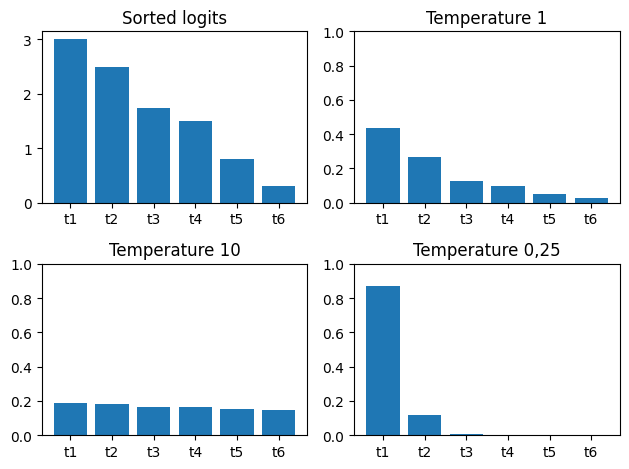

In [4]:
dist = np.array([3, 2.5, 1.75, 1.5, 0.8, 0.3])

softmax_dist = softmax(dist)
softmax_dist_high = softmax(dist, 1 / 10)
softmax_dist_low = softmax(dist, 1 / 0.25)

fig, axes = plt.subplots(nrows=2, ncols=2)

plot_distribution(axes[0][0], dist, "Sorted logits", False)
plot_distribution(axes[0][1], softmax_dist, "Temperature 1")
plot_distribution(axes[1][0], softmax_dist_high, "Temperature 10")
plot_distribution(axes[1][1], softmax_dist_low, "Temperature 0,25")

plt.tight_layout()
plt.show()

In [5]:
@interact(t=(0.01, 10, 0.01))
def plot_temperature_chart(t: float = 1) -> None:
    dist = np.array([3, 2.5, 1.75, 1.5, 0.8, 0.3])
    n_elements = len(dist)

    softmax_dist = softmax(dist, 1 / t)

    fig, axes = plt.subplots(nrows=1, ncols=2)

    plot_distribution(axes[0], dist, "Logits", False)
    plot_distribution(axes[1], softmax_dist, f"Temperature {t}")

interactive(children=(FloatSlider(value=1.0, description='t', max=10.0, min=0.01, step=0.01), Output()), _dom_…

## Top k sampling

Unlike the temperature the Top k sampling does not change the output discrete probability distribution from the underlying transformer model. This method consists of three steps:

1. order the tokens in descending order of probability
2. select the first k tokens and create a new distribution out of these k tokens (if we select a subset we need to normalize the selection to obtain a new distribution)
3. sample from this new distribution

Because $k$ is a fixed number we get a static number of tokens. For $k=1$ we call it a **greedy strategy**.

In [6]:
def top_k_sampling(dist: np.array, top_k: int) -> np.array:
    assert top_k > 0, "top_k should be > 0"

    sorted_dist = sorted(dist, reverse=True)
    sample = sorted_dist[:top_k]
    
    return sample / sum(sample)

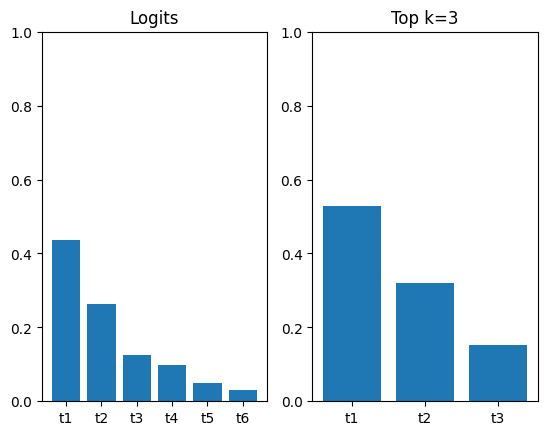

In [7]:
dist = np.array([3, 2.5, 1.75, 1.5, 0.8, 0.3])
softmax_dist = softmax(dist)

sample = top_k_sampling(softmax_dist, 3)

fig, axes = plt.subplots(nrows=1, ncols=2)

plot_distribution(axes[0], softmax_dist, "Logits")
plot_distribution(axes[1], sample, f"Top k={3}")

In [8]:
@interact(top_k=(1, 6, 1))
def plot_top_k_chart(top_k: int = 1) -> None:
    dist = np.array([3, 2.5, 1.75, 1.5, 0.8, 0.3])
    softmax_dist = softmax(dist)

    sample = top_k_sampling(softmax_dist, top_k)

    fig, axes = plt.subplots(nrows=1, ncols=2)

    plot_distribution(axes[0], softmax_dist, "Logits")
    plot_distribution(axes[1], sample, f"Top k={top_k}")


interactive(children=(IntSlider(value=1, description='top_k', max=6, min=1), Output()), _dom_classes=('widget-…

## Top p sampling (nucleus sampling)

The Top p sampling method is similar to Top k sampling, but instead of selecting a fixed number of tokens we select a dynamic number of tokens depending on the probability distribution. Again, this method consists of three steps:

1. order the tokens in descending order of probability
2. select the smallest number of tokens such that theire cumulative probability is at least p
3. sample from this new distribution

In [9]:
def top_p_sampling(dist: np.array, top_p: float) -> np.array:
    assert top_p >= 0, "top_p should be >= 0"
    assert top_p <= 1, "top_p should be <= 1"

    sorted_dist = sorted(dist, reverse=True)
    cumulative_probs = np.cumsum(sorted_dist)

    threshold_index = np.where(cumulative_probs >= top_p)[0][0]

    sample = sorted_dist[:threshold_index + 1]

    return sample / sum(sample)

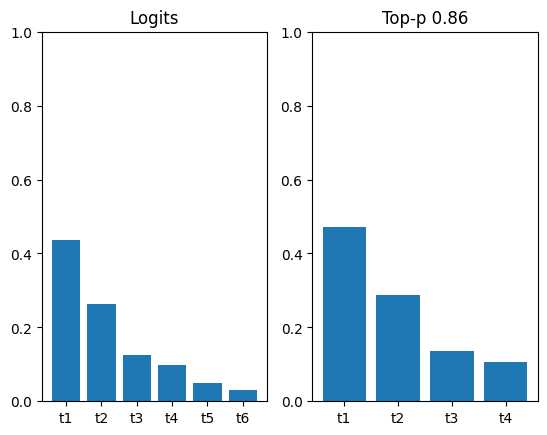

In [10]:
dist = np.array([3, 2.5, 1.75, 1.5, 0.8, 0.3])
softmax_dist = softmax(dist)

sample = top_p_sampling(softmax_dist, 0.86)

fig, axes = plt.subplots(nrows=1, ncols=2)

plot_distribution(axes[0], softmax_dist, "Logits")
plot_distribution(axes[1], sample, f"Top-p {0.86}")

In [11]:
@interact(top_p=(0, 1, 0.01))
def plot_top_p_chart(top_p: float = 0.5) -> None:
    dist = np.array([3, 2.5, 1.75, 1.5, 0.8, 0.3])
    softmax_dist = softmax(dist)

    sample = top_p_sampling(softmax_dist, top_p)

    fig, axes = plt.subplots(nrows=1, ncols=2)

    plot_distribution(axes[0], softmax_dist, "Logits")
    plot_distribution(axes[1], sample, f"Top-p {top_p}")

interactive(children=(FloatSlider(value=0.5, description='top_p', max=1.0, step=0.01), Output()), _dom_classes…